Deep Learning
=============

Assignment 1
------------

The objective of this assignment is to learn about simple data curation practices, and familiarize you with some of the data we'll be reusing later.

This notebook uses the [notMNIST](http://yaroslavvb.blogspot.com/2011/09/notmnist-dataset.html) dataset to be used with python experiments. This dataset is designed to look like the classic [MNIST](http://yann.lecun.com/exdb/mnist/) dataset, while looking a little more like real data: it's a harder task, and the data is a lot less 'clean' than MNIST.

In [1]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
import matplotlib.pyplot as plt
import numpy as np
import os
import tarfile
import urllib
from IPython.display import display, Image
from scipy import ndimage
from sklearn.linear_model import LogisticRegression as LR
from sklearn.linear_model import SGDClassifier as SGD
import cPickle as pickle

### Downloading and Loading Data(skip this)

First, we'll download the dataset to our local machine. The data consists of characters rendered in a variety of fonts on a 28x28 image. The labels are limited to 'A' through 'J' (10 classes). The training set has about 500k and the testset 19000 labelled examples. Given these sizes, it should be possible to train models quickly on any machine.

In [3]:
# Don't do this if all files are already in the directory
url = 'http://yaroslavvb.com/upload/notMNIST/'

def maybe_download(filename, expected_bytes):
  """Download a file if not present, and make sure it's the right size."""
  if not os.path.exists(filename):
    filename, _ = urllib.urlretrieve(url + filename, filename)
  statinfo = os.stat(filename)
  if statinfo.st_size == expected_bytes:
    print 'Found and verified', filename
  else:
    raise Exception(
      'Failed to verify' + filename + '. Can you get to it with a browser?')
  return filename

train_filename = maybe_download('notMNIST_large.tar.gz', 247336696)
test_filename = maybe_download('notMNIST_small.tar.gz', 8458043)

Found and verified notMNIST_large.tar.gz
Found and verified notMNIST_small.tar.gz


Extract the dataset from the compressed .tar.gz file.
This should give you a set of directories, labelled A through J.

In [4]:
# Don't do this, if all files are already in the directory
num_classes = 10

def extract(filename):
  tar = tarfile.open(filename)
  tar.extractall()
  tar.close()
  root = os.path.splitext(os.path.splitext(filename)[0])[0]  # remove .tar.gz
  data_folders = [os.path.join(root, d) for d in sorted(os.listdir(root))]
  if len(data_folders) != num_classes:
    raise Exception(
      'Expected %d folders, one per class. Found %d instead.' % (
        num_classes, len(data_folders)))
  print data_folders
  return data_folders
  
train_folders = extract(train_filename)
test_folders = extract(test_filename)

['notMNIST_large/A', 'notMNIST_large/B', 'notMNIST_large/C', 'notMNIST_large/D', 'notMNIST_large/E', 'notMNIST_large/F', 'notMNIST_large/G', 'notMNIST_large/H', 'notMNIST_large/I', 'notMNIST_large/J']
['notMNIST_small/A', 'notMNIST_small/B', 'notMNIST_small/C', 'notMNIST_small/D', 'notMNIST_small/E', 'notMNIST_small/F', 'notMNIST_small/G', 'notMNIST_small/H', 'notMNIST_small/I', 'notMNIST_small/J']


In [2]:
# Do this instead
train_folders = ['notMNIST_large/A', 'notMNIST_large/B', 'notMNIST_large/C',\
                 'notMNIST_large/D', 'notMNIST_large/E', 'notMNIST_large/F',\
                 'notMNIST_large/G', 'notMNIST_large/H', 'notMNIST_large/I', 'notMNIST_large/J']
test_folders = ['notMNIST_small/A', 'notMNIST_small/B', 'notMNIST_small/C',\
                'notMNIST_small/D', 'notMNIST_small/E', 'notMNIST_small/F',\
                'notMNIST_small/G', 'notMNIST_small/H', 'notMNIST_small/I', 'notMNIST_small/J']

---
Problem 1
---------

Let's take a peek at some of the data to make sure it looks sensible. Each exemplar should be an image of a character A through J rendered in a different font. Display a sample of the images that we just downloaded. Hint: you can use the package IPython.display.

---

In [3]:
# Get a random image from <directory> and display it
def sampleImage(directoryName):
    randomFile = np.random.choice(os.listdir(directoryName))
    return Image(filename=os.path.join(directoryName,randomFile))

# Sample a letter from each directory in the test_folders
[display(sampleImage(f)) for f in test_folders]

[None, None, None, None, None, None, None, None, None, None]

Note that the images above are grayscale

Now let's load the data in a more manageable format.

We'll convert the entire dataset into a 3D array (image index, x, y) of floating point values, normalized to have approximately zero mean and standard deviation ~0.5 to make training easier down the road. The labels will be stored into a separate array of integers 0 through 9.

A few images might not be readable, we'll just skip them.

In [4]:
# Modifiy the dataset size if you want to quickly run it in the laptop
image_size = 28  # Pixel width and height.
pixel_depth = 255.0  # Number of levels per pixel.

def load(data_folders, min_num_images, max_num_images):
    # ndarray to hold values, w/ upper bounds on size
  dataset = np.ndarray(shape=(max_num_images, image_size, image_size), dtype=np.float32) 
    #ndarray to hold labels, w/ upper bounds on size
  labels = np.ndarray(shape=(max_num_images), dtype=np.int32) 
  label_index = 0
  image_index = 0 # index for loop
#  max_num_images_per_class = max_num_images//10 # code to shrink the loop size
  for folder in data_folders: # loop for each class
    print folder # display the working class
#    idx_in_this_class = 0; # code to shrink the loop size
    for image in os.listdir(folder): # Loop for images in a single class
      # if idx_in_this_class >= max_num_images_per_class:
#        break;
      if image_index >= max_num_images:
        # break;
        # original code(below):
        raise Exception('More images than expected: %d >= %d' % (num_images, max_num_images))
      image_file = os.path.join(folder, image) # full path of the image file we're working on
      try:
        image_data = (ndimage.imread(image_file).astype(float) - pixel_depth / 2) / pixel_depth
        # normalize each pixels to have approximately zero mean and small variance(each sample has maximum std of 0.5)
        # ndimage is a scipy package for multi-dimensional image processing
        # ndimage.imread reads an image from a file as an ndarray, where the first argument is the filename or the file object.
        if image_data.shape != (image_size, image_size):
          raise Exception('Unexpected image shape: %s' % str(image_data.shape))
        dataset[image_index, :, :] = image_data # save the image
        labels[image_index] = label_index # save the class label(identical over the same folder)
        image_index += 1 # increment the loop index
#        idx_in_this_class += 1 # code to shrink the loop size
      except IOError as e:
        print 'Could not read:', image_file, ':', e, '- it\'s ok, skipping.'
    label_index += 1
  num_images = image_index
  dataset = dataset[0:num_images, :, :] # only use the existing images
  labels = labels[0:num_images]  # only use the existing labels
  if num_images < min_num_images:
    raise Exception('Many fewer images than expected: %d < %d' % (num_images, min_num_images))
# Statistics about the whole dataset
  print 'Full dataset tensor:', dataset.shape
  print 'Mean:', np.mean(dataset)
  print 'Standard deviation:', np.std(dataset)
  print 'Labels:', labels.shape
  return dataset, labels
train_dataset, train_labels = load(train_folders, 450000, 550000)
test_dataset, test_labels = load(test_folders, 18000, 20000)
# initially, (min_num_images, max_num_images) were
# training set: (45*10^4, 55*10^4)
# test set: (18*10^3, 20*10^3)

notMNIST_large/A
Could not read: notMNIST_large/A/SG90IE11c3RhcmQgQlROIFBvc3Rlci50dGY=.png : cannot identify image file 'notMNIST_large/A/SG90IE11c3RhcmQgQlROIFBvc3Rlci50dGY=.png' - it's ok, skipping.
Could not read: notMNIST_large/A/Um9tYW5hIEJvbGQucGZi.png : cannot identify image file 'notMNIST_large/A/Um9tYW5hIEJvbGQucGZi.png' - it's ok, skipping.
Could not read: notMNIST_large/A/RnJlaWdodERpc3BCb29rSXRhbGljLnR0Zg==.png : cannot identify image file 'notMNIST_large/A/RnJlaWdodERpc3BCb29rSXRhbGljLnR0Zg==.png' - it's ok, skipping.
notMNIST_large/B
Could not read: notMNIST_large/B/TmlraXNFRi1TZW1pQm9sZEl0YWxpYy5vdGY=.png : cannot identify image file 'notMNIST_large/B/TmlraXNFRi1TZW1pQm9sZEl0YWxpYy5vdGY=.png' - it's ok, skipping.
notMNIST_large/C
notMNIST_large/D
Could not read: notMNIST_large/D/VHJhbnNpdCBCb2xkLnR0Zg==.png : cannot identify image file 'notMNIST_large/D/VHJhbnNpdCBCb2xkLnR0Zg==.png' - it's ok, skipping.
notMNIST_large/E
notMNIST_large/F
notMNIST_large/G
notMNIST_large/H


---
Problem 2
---------

Let's verify that the data still looks good. Displaying a sample of the labels and images from the ndarray. Hint: you can use matplotlib.pyplot.

---

#### Load data file in a pickle

In [2]:
pickle_file = 'notMNIST.pickle'

with open(pickle_file, 'rb') as f:
  save = pickle.load(f)
  train_dataset = save['train_dataset']
  train_labels = save['train_labels']
  valid_dataset = save['valid_dataset']
  valid_labels = save['valid_labels']
  test_dataset = save['test_dataset']
  test_labels = save['test_labels']
  del save  # hint to help gc free up memory
  print 'Training set', train_dataset.shape, train_labels.shape
  print 'Validation set', valid_dataset.shape, valid_labels.shape
  print 'Test set', test_dataset.shape, test_labels.shape

Training set (352743, 28, 28) (352743,)
Validation set (176371, 28, 28) (176371,)
Test set (18724, 28, 28) (18724,)


('class', 'A', 35171)
('class', 'B', 35539)
('class', 'C', 35181)
('class', 'D', 35408)
('class', 'E', 35189)
('class', 'F', 35310)
('class', 'G', 35141)
('class', 'H', 35165)
('class', 'I', 35325)
('class', 'J', 35314)


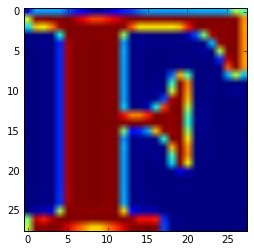

In [3]:
%matplotlib inline
# Get a random image
random_image = train_dataset[np.random.randint(2000)]
imgplot = plt.imshow(random_image)

# plot
#display how many classes are in the set
for i in range(ord('A'),ord('J')+1):
    print('class',chr(i),np.sum(train_labels==i-ord('A')))

Next, we'll randomize the data. It's important to have the labels well shuffled for the training and test distributions to match.

In [4]:
np.random.seed(133)
def randomize(dataset, labels):
  permutation = np.random.permutation(labels.shape[0])
  shuffled_dataset = dataset[permutation,:,:]
  shuffled_labels = labels[permutation]
  return shuffled_dataset, shuffled_labels
train_dataset, train_labels = randomize(train_dataset, train_labels)
test_dataset, test_labels = randomize(test_dataset, test_labels)

---
Problem 3
---------
Convince yourself that the data is still good after shuffling!

---

('class', 'A', 1872)
('class', 'B', 1873)
('class', 'C', 1873)
('class', 'D', 1873)
('class', 'E', 1873)
('class', 'F', 1872)
('class', 'G', 1872)
('class', 'H', 1872)
('class', 'I', 1872)
('class', 'J', 1872)


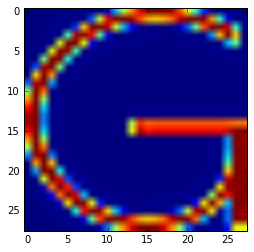

In [5]:
# Get a random image
random_image = test_dataset[np.random.randint(2000)]
imgplot = plt.imshow(random_image)

# plot
#display how many classes are in the set
for i in range(ord('A'),ord('J')+1):
    print('class',chr(i),np.sum(test_labels==i-ord('A')))

---
Problem 4
---------
Another check: we expect the data to be balanced across classes. Verify that.

---

### Skip this part, since we already saved the data in pickles, where the data is divided into Training/Validation/Test set

Prune the training data as needed. Depending on your computer setup, you might not be able to fit it all in memory, and you can tune train_size as needed.

Also create a validation dataset for hyperparameter tuning.

In [8]:
train_size = 529114-529114//3
valid_size = 529114//3

valid_dataset = train_dataset[:valid_size,:,:]
valid_labels = train_labels[:valid_size]
train_dataset = train_dataset[valid_size:valid_size+train_size,:,:]
train_labels = train_labels[valid_size:valid_size+train_size]

print 'Training', train_dataset.shape, train_labels.shape
print 'Validation', valid_dataset.shape, valid_labels.shape

Training (352743, 28, 28) (352743,)
Validation (176371, 28, 28) (176371,)


Finally, let's save the data for later reuse:

In [11]:
pickle_file = 'notMNIST.pickle'

try:
  f = open(pickle_file, 'wb')
  save = {
    'train_dataset': train_dataset,
    'train_labels': train_labels,
    'valid_dataset': valid_dataset,
    'valid_labels': valid_labels,
    'test_dataset': test_dataset,
    'test_labels': test_labels,
    }
  pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
  f.close()
except Exception as e:
  print 'Unable to save data to', pickle_file, ':', e
  raise

In [12]:
statinfo = os.stat(pickle_file)
print 'Compressed pickle size:', statinfo.st_size

Compressed pickle size: 1720211765


---
Problem 5
---------

By construction, this dataset might contain a lot of overlapping samples, including training data that's also contained in the validation and test set! Overlap between training and test can skew the results if you expect to use your model in an environment where there is never an overlap, but are actually ok if you expect to see training samples recur when you use it.
Measure how much overlap there is between training, validation and test samples.
Optional questions:
- What about near duplicates between datasets? (images that are almost identical)
- Create a sanitized validation and test set, and compare your accuracy on those in subsequent assignments.
---

In [ ]:
# Don't do this, since it takes quite a long time
duplicates = 0.0
for image_test in test_dataset:
    for image_val in valid_dataset:
        for image_train in train_dataset:
            # you may use np.array_equal for safety. (A==B).all() is prone to subtle errors but faster
            eq1 = (image_test==image_train).all()
            eq2 = (image_test==image_val).all()
            eq3 = (image_train==image_val).all()
            if eq1 or eq2 or eq3:
                duplicates += 1
print(duplicates/5500)

---
Problem 6
---------

Let's get an idea of what an off-the-shelf classifier can give you on this data. It's always good to check that there is something to learn, and that it's a problem that is not so trivial that a canned solution solves it.

Train a simple model on this data using 50, 100, 1000 and 5000 training samples. Hint: you can use the LogisticRegression model from sklearn.linear_model.

Optional question: train an off-the-shelf model on all the data!

---

In [6]:
(n_train, width, height) = train_dataset.shape
#n_valid = valid_dataset.shape[0]
#n_test = test_dataset.shape[0]

n_train = 7000
#n_valid = 2000
n_test = 2000
X_train = np.reshape(train_dataset[:n_train],(n_train, width*height)) # reshape the array, with reading elements by rows.
y_train = train_labels[:n_train]
#X_valid = np.reshape(valid_dataset[:n_valid],(n_valid, width*height))
#y_valid = valid_labels[:n_valid]
X_test = np.reshape(test_dataset[:n_test],(n_test, width*height))
y_test = test_labels[:n_test]

In [7]:
from sklearn import cross_validation ## prepare for the cross-validation

In [8]:
clf_LR = LR().fit(X_train,y_train) # fit the L2-regularized Logistic regression model
# training set score with 5-fold cross-validation
training_accuracy= \
cross_validation.cross_val_score(clf_LR,X_train,y_train,cv=5).mean()
test_accuracy = clf_LR.score(X_test, y_test) # test set score
print('initial training accuracy: ',training_accuracy)
print('initial test accuracy: ',test_accuracy)

('initial training accuracy: ', 0.78328482900700225)
('initial test accuracy: ', 0.84150000000000003)


In [9]:
# fit the L2-regularized Logistic regression model w/ SGD(much faster)
clf_SGD_LR = SGD(loss="log").fit(X_train,y_train)
training_accuracy = \
cross_validation.cross_val_score(clf_SGD_LR,X_train,y_train,cv=5).mean()
test_accuracy = clf_SGD_LR.score(X_test, y_test) # test set score
print(training_accuracy)
print(test_accuracy)
print('initial training accuracy: ',training_accuracy)
print('initial test accuracy: ',test_accuracy)

0.775139556952
0.8275
('initial training accuracy: ', 0.77513955695178605)
('initial test accuracy: ', 0.82750000000000001)


In [11]:
# Parameter tuning (using binary search)
clf_SGD_LR_tuned = SGD(loss="log").fit(X_train,y_train)
best_score = clf_SGD_LR_tuned.score(X_train,y_train)
best_alpha = 0.0001
current_alpha = 0.0001/2
count_stuck = 0
pos_grad = False
for i in range(10):
    clf_SGD_LR_tuned = SGD(loss="log",alpha=current_alpha).fit(X_train,y_train)
    # new score
    new_score =\
    cross_validation.cross_val_score(clf_SGD_LR_tuned,X_train,y_train,cv=5).mean()
    if best_score <= new_score: # if improved, proceed
        best_alpha = current_alpha
        if pos_grad:
            current_alpha = current_alpha * 2
        else:
            current_alpha = current_alpha / 2
    else:
        if pos_grad:
            pos_grad = False
            current_alpha = current_alpha / 2
        else:
            pos_grad = True
            current_alpha = current_alpha * 2
training_accuracy = clf_SGD_LR_tuned.score(X_train,y_train)
test_accuracy = clf_SGD_LR_tuned.score(X_test,y_test)
print('alpha: ',best_alpha)
print('training accuracy a/f tuning: ',training_accuracy)
print('test accuracy a/f tuning: ',test_accuracy)

('alpha: ', 0.0001)
('training accuracy a/f tuning: ', 0.82128571428571429)
('test accuracy a/f tuning: ', 0.81999999999999995)


In [12]:
# fit the L2-regularized linear SVM w/ SGD
clf_SGD_SVM = SGD(loss="hinge").fit(X_train,y_train)
training_accuracy = \
cross_validation.cross_val_score(clf_SGD_SVM,X_train,y_train,cv=5).mean() # training set score
test_accuracy = clf_SGD_SVM.score(X_test, y_test) # test set score
print(training_accuracy)
print(test_accuracy)

0.774852734718
0.827


In [14]:
# Parameter tuning (using binary search) ==> terrible performance
clf_SGD_SVM_tuned = SGD(loss="hinge").fit(X_train,y_train)
best_score = clf_SGD_SVM_tuned.score(X_train,y_train)
best_alpha = 0.0001
current_alpha = 0.0001/2
count_stuck = 0
pos_grad = False
for i in range(10):
    clf_SGD_SVM_tuned = SGD(loss="log",alpha=current_alpha).fit(X_train,y_train)
    # new validation score
    new_score = \
    cross_validation.cross_val_score(clf_SGD_SVM_tuned,X_train,y_train,cv=5).mean()
    if best_score <= new_score: # if improved, proceed
        best_alpha = current_alpha
        if pos_grad:
            current_alpha = current_alpha * 2
        else:
            current_alpha = current_alpha / 2
    else:
        if pos_grad:
            pos_grad = False
            current_alpha = current_alpha / 2
        else:
            pos_grad = True
            current_alpha = current_alpha * 2
training_accuracy = clf_SGD_SVM_tuned.score(X_train,y_train)
test_accuracy = clf_SGD_SVM_tuned.score(X_test,y_test)
print('alpha: ',best_alpha)
print('training accuracy a/f tuning: ',training_accuracy)
print('test accuracy a/f tuning: ',test_accuracy)

('alpha: ', 0.0001)
('training accuracy a/f tuning: ', 0.79785714285714282)
('test accuracy a/f tuning: ', 0.80200000000000005)
